In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools

import warnings
warnings.filterwarnings('ignore')

temp = os.getcwd()
print(f'Current working directory: {temp}')
if '/project1' in temp:
    temp = temp.replace('/project1', '')
    os.chdir(temp)
    print(f'Switched to: {temp}')

Current working directory: /Users/timmaier/Dropbox/uni/master/semester4/TSA/Research Project/time-series


In [3]:
data = pd.read_excel('data/QualidadeARO3.xlsx')
data = data.drop(columns='Ihavo')
rng = pd.date_range('1/1/2020 00:00', periods=8784, freq='1H')
data.index = rng

In [4]:
data.shape

(8784, 9)

# 1. Fit SARIMA type model

## (a) initial examination of the data

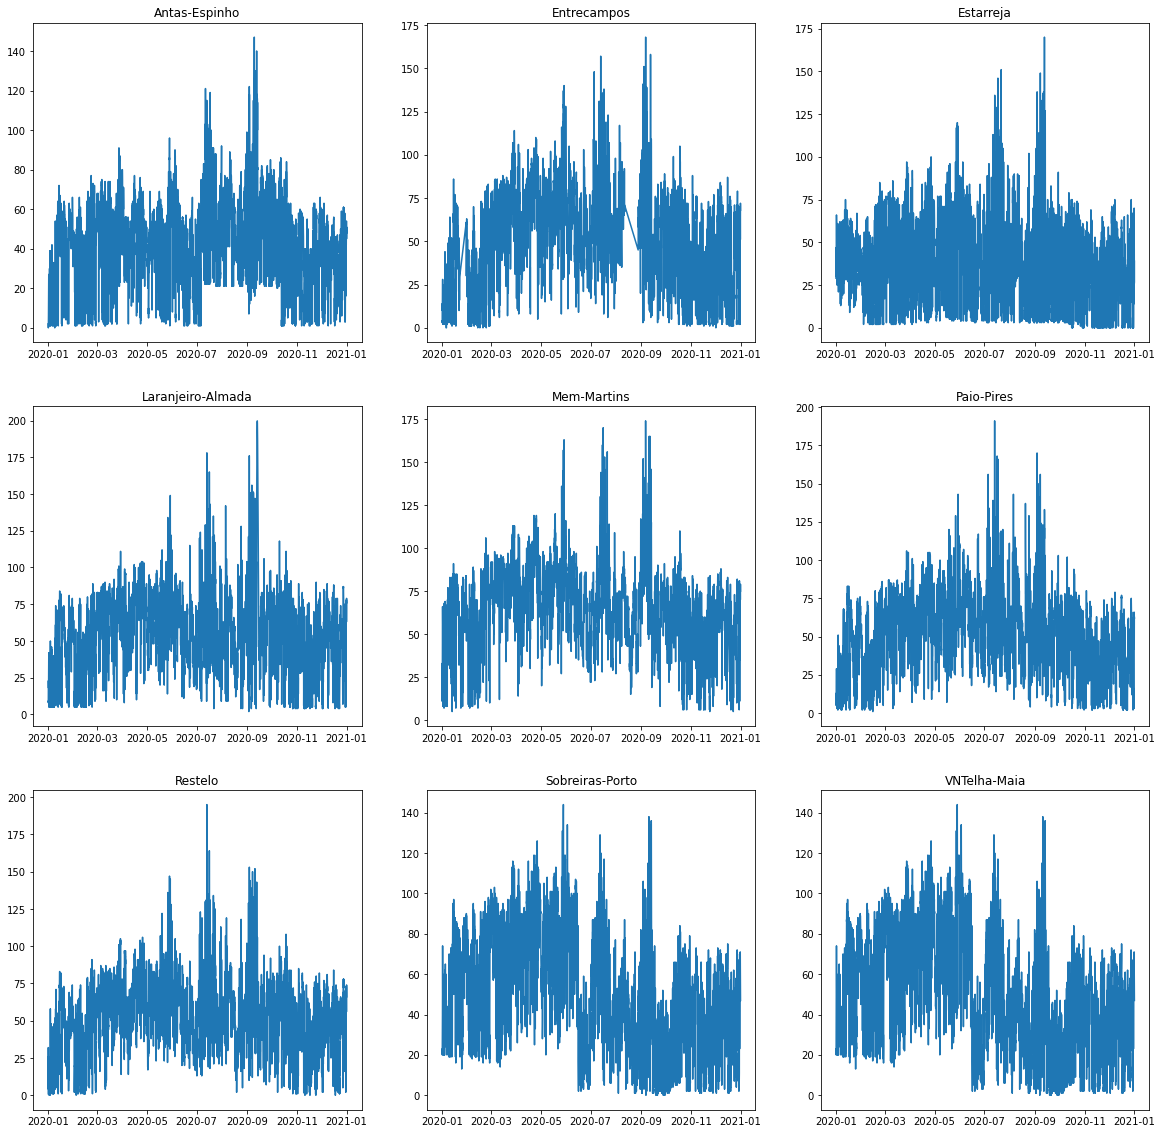

In [12]:
plt.figure(figsize=(20,20))
for idx, o2levels in enumerate(data.columns):
    plt.subplot(3, 3, idx+1)
    plt.plot(data.index, data[o2levels])
    plt.gca().set_title(o2levels)
plt.show()

## (b) transformations if necessary

In [6]:
adf_df = pd.DataFrame(index=data.columns, columns=['ADF_Statistic', 'p_value', 'Stationary'])
sig_level = 0.05

for i in range(0,data.shape[1]):
    adf_tmp = adfuller(data.iloc[:,i])
    adf_df.iloc[i,0] = adf_tmp[0]
    adf_df.iloc[i,1] = adf_tmp[1]
    adf_df.iloc[i,2] = True if adf_tmp[1] < sig_level else False


In [7]:
adf_df.Stationary

Antas-Espinho        True
Entrecampos          True
Estarreja            True
Laranjeiro-Almada    True
Mem-Martins          True
Paio-Pires           True
Restelo              True
Sobreiras-Porto      True
VNTelha-Maia         True
Name: Stationary, dtype: object

we perform the Augmented Dickey-Fuller test to check for the stationarity condition 

our null hypothesis is that the time series is not stationary and the alternative is that it is indeed stationary

when testing with a significance level of 0.05, we see that the p-value for the statistic for all given time series is smaller that our level, thus we can conclude that our time series are stationary and we don't need any further transformations

## (c) initial identification of dependence orders

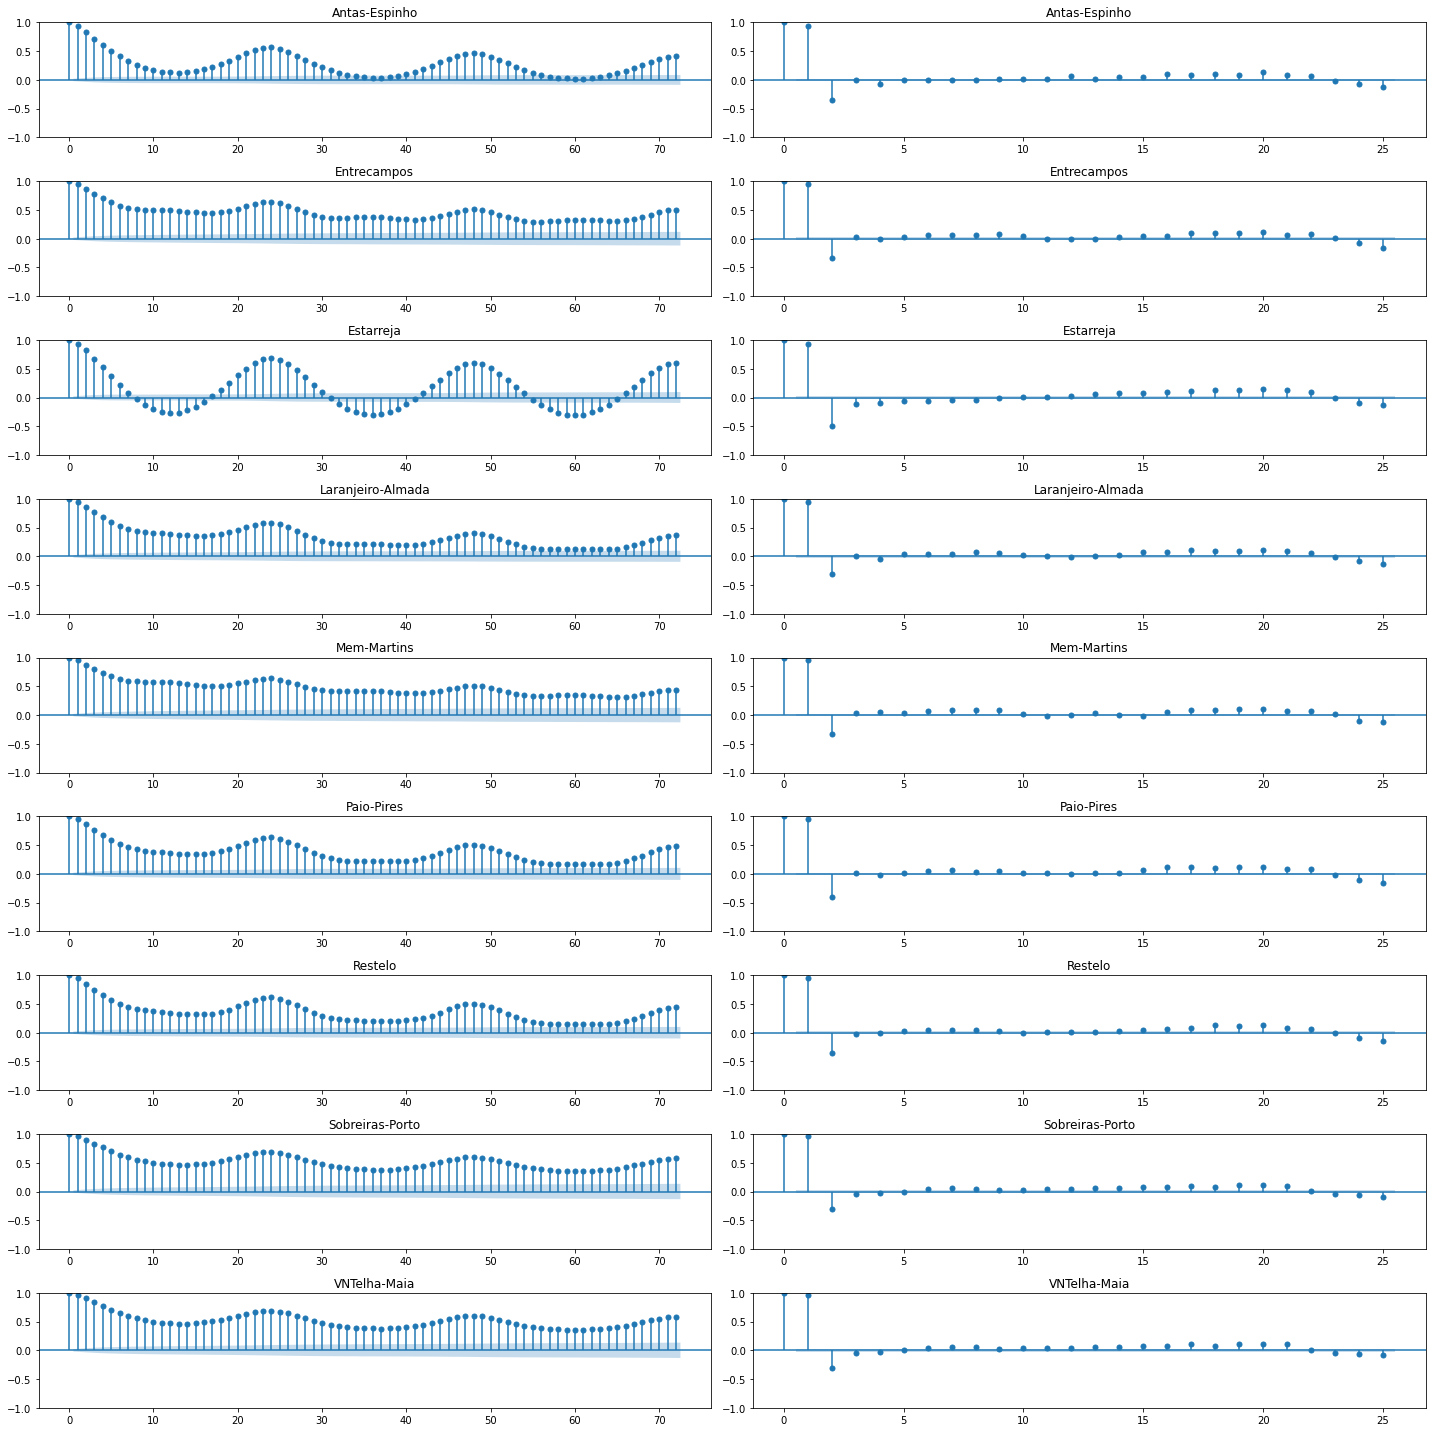

In [15]:
fig = plt.figure(figsize=(20,20))

for idx, o2levels in enumerate(data.columns):
    plot_acf(data[o2levels], lags=72, title=o2levels, ax=plt.subplot(9, 2, idx*2+1))
    plot_pacf(data[o2levels], lags=25, title=o2levels, ax=plt.subplot(9, 2, idx*2+2))

fig.tight_layout()
plt.show()

when having a look at the pacf's of the time series we can see a strong peak at lag 1 which suggests an AR(1) process

when having a look at the acf's of the time series we can see strong peaks at the lags (0,) 24, 48 etc ie seasonality of 24!

'In fact, looking closely, we can see some sinusoidal shape in both ACF and PACF functions. This suggests that both processes are in play' - (https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d)

## (d) parameter estimation

as described in (b) we know that our time series are stationary hence there is no trend
since we don't have a trend we know that d=0
the sinus shape of both the acf and pacf suggests that both AR and MA are in play
further we already established that we have S=24
thus we are left with four free parameters: p, q, P, Q

In [22]:
endog = data.Entrecampos
p_list = list(range(0,2))
q_list = list(range(0,2))
P_list = list(range(0,2))
Q_list = list(range(0,2))
model_dict = {}

for p,q,P,Q in itertools.product(p_list, q_list, P_list, Q_list):
    #print(f'{p},{q},{P},{Q}')
    model_fit = SARIMAX(endog, order=(p,0,q), seasonal_order=(P,0,Q, 24)).fit(disp=False) #normal fitten? in towardsdatascience .fit(disp=-1)
    model_dict[f'{p},{q},{P},{Q}'] = (model_fit.bic, model_fit.aic, model_fit)
    print(f'{p},{q},{P},{Q}: {model_fit.bic},{model_fit.aic}')


0,0,0,0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50289D+00    |proj g|=  2.75335D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.753D-09   5.503D+00
  F =   5.5028879732824265     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0,0,0,0: 96683.81660178941,96676.73591462566
0,0,0,1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26892D+00    |proj g|=  1.93730D-01


 This problem is unconstrained.



At iterate    5    f=  5.22331D+00    |proj g|=  9.37330D-03

At iterate   10    f=  5.10751D+00    |proj g|=  8.45714D-02

At iterate   15    f=  5.09605D+00    |proj g|=  1.86073D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     18      1     0     0   1.861D-07   5.096D+00
  F =   5.0960459509213667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0,0,0,1: 89545.49664011407,89531.33526578658
0,0,1,0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   4.619D-07   4.542D+00
  F =   4.5417210703515902     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0,0,1,0: 79807.11713826424,79792.95576393674
0,0,1,1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47809D+00    |proj g|=  5.73689D-02

At iterate    5    f=  4.43430D+00    |proj g|=  2.89739D-02

At iterate   10    f=  4.42012D+00    |proj g|=  3.25777D-03

At iterate   15    f=  4.41890D+00    |proj g|=  3.89193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   5.704D-06   4.419D+00
  F =   4.4189026694274451     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0,0,1,1:

 This problem is unconstrained.



At iterate    5    f=  5.12140D+00    |proj g|=  1.20138D-02

At iterate   10    f=  4.88995D+00    |proj g|=  1.92513D-02

At iterate   15    f=  4.88460D+00    |proj g|=  6.66223D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     17      1     0     0   6.662D-06   4.885D+00
  F =   4.8846038307377695     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0,1,0,0: 85830.88147272862,85816.72009840113
0,1,0,1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25993D+00    |proj g|=  5.36135D-01

At iterate    5    f=  5.00618D+00    |proj g|=  1.50512D-02

At iterate   10    f=  4.79065D+00    |proj g|=  1.57412D-01

At iterate   15    f=  4.54842D+00    |proj g|=  6.05839D-03

At iterate   20    f=  4.54201D+00    |proj g|=  3.41389D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   3.414D-06   4.542D+00
  F =   4.5420136122149017     

CONVERG

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.06381D+00    |proj g|=  1.36039D-01

At iterate    5    f=  4.44169D+00    |proj g|=  1.87168D-02

At iterate   10    f=  4.14712D+00    |proj g|=  1.91262D-02
  ys=-4.022E-02  -gs= 3.773E-02 BFGS update SKIPPED

At iterate   15    f=  4.10814D+00    |proj g|=  1.59182D-03
  ys=-5.322E-03  -gs= 5.457E-03 BFGS update SKIPPED

At iterate   20    f=  4.08912D+00    |proj g|=  9.06567D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     53      1     2     0   1.130D-05   4.085D+00
  F =   4.0854794197765862     

CONVERGENCE: REL_

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05342D+00    |proj g|=  1.21750D-01

At iterate    5    f=  4.36886D+00    |proj g|=  2.70575D-02

At iterate   10    f=  4.36734D+00    |proj g|=  6.29640D-03

At iterate   15    f=  4.36185D+00    |proj g|=  2.63693D-03

At iterate   20    f=  4.32593D+00    |proj g|=  1.94959D-01

At iterate   25    f=  4.14766D+00    |proj g|=  3.60978D-01

At iterate   30    f=  3.97456D+00    |proj g|=  5.87454D-02

At iterate   35    f=  3.94404D+00    |proj g|=  6.63703D-03

At iterate   40    f=  3.94281D+00    |proj g|=  2.50052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   2.759D-07   3.586D+00
  F =   3.5857837767069589     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1,0,0,0: 63013.21076351535,62999.04938918785
1,0,0,1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58513D+00    |proj g|=  2.58874D-01

At iterate    5    f=  3.54926D+00    |proj g|=  5.45201D-03

At iterate   10    f=  3.54924D+00    |proj g|=  2.69665D-03

At iterate   15    f=  3.54900D+00    |proj g|=  3.16990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   1.280D-06   3.549D+00
  F =   3.5489827553595528     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1,0,0,1:

 This problem is unconstrained.



At iterate    5    f=  3.53488D+00    |proj g|=  1.42694D-02

At iterate   10    f=  3.53467D+00    |proj g|=  2.90415D-03

At iterate   15    f=  3.53389D+00    |proj g|=  9.03413D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     25      1     0     0   1.077D-05   3.534D+00
  F =   3.5338906173079527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1,0,1,0: 62110.63242635736,62089.390364866114
1,0,1,1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f=  3.47010D+00    |proj g|=  8.84105D-03

At iterate   10    f=  3.45424D+00    |proj g|=  7.84629D-03

At iterate   15    f=  3.45136D+00    |proj g|=  5.94560D-04

At iterate   20    f=  3.45116D+00    |proj g|=  1.54069D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   5.477D-06   3.451D+00
  F =   3.4511610338064802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1,0,1,1: 60666.31979056724,60637.99704191225
1,1,0,0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53483D+00    |proj g|=  2.18565D-02

At iterate    5    f=  3.53457D+00    |proj g|=  1.63945D-04

At iterate   10    f=  3.53456D+00    |proj g|=  8.54661D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   1.024D-06   3.535D+00
  F =   3.5345632035437839     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1,1,0,0: 62122.44842134845,62101.2063598572
1,1,0,1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56629D+00    |proj g|=  3.21934D-01

At iterate    5    f=  3.51221D+00    |proj g|=  9.49521D-03

At iterate   10    f=  3.51198D+00    |proj g|=  2.03079D-03


KeyboardInterrupt: 

In [ ]:
model = arch_model(edp['Log-Return'], mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit()
print(model_fit.summary)
# was macht man jetzt damit

p_list = list(range(1, 10))
q_list = list(range(1, 10))
model_dict = {}

for p,q in itertools.product(p_list, q_list):
    model = arch_model(edp['Log-Return'], mean='Zero', vol='GARCH', p=p, q=q, rescale=False)
    model_fit = model.fit()
    model_dict[f'{p},{q}'] = (model_fit.bic, model_fit)
    print(f'{p},{q}: {model_fit.aic}')

## (e) residual diagnostics and model choice